# Ookla Internet - Fixed Internet Analysis

## Annual Trends (Download and Upload Speeds)

### Download Trends

In [5]:
DATA_DIR = "../../data/processed_data/"

In [14]:

import pandas as pd
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool

output_notebook(hide_banner=True)

df = pd.read_csv(str(DATA_DIR) + "algeria_national_trends_fixed.csv").copy()
df['year'] = df['date'].str.slice(0, 4).astype(int)
yearly = (df.groupby('year', as_index=False)[['avg_download_mbps', 'avg_upload_mbps']]
            .mean().rename(columns={'avg_download_mbps':'download_mbps', 'avg_upload_mbps':'upload_mbps'}))
yearly = yearly.sort_values('year')

src = ColumnDataSource(yearly)

p = figure(title="Algeria – Yearly Download and Upload Speed (Mbps)",
           x_axis_type="linear", height=400, width=800,
           tools="pan,wheel_zoom,box_zoom,reset,save")

p.line('year', 'download_mbps', source=src, line_width=3)
p.line('year', 'upload_mbps', source=src, line_width=3, color='orange')
p.scatter('year', 'download_mbps', source=src, size=8)
p.scatter('year', 'upload_mbps', source=src, size=8, color='orange')

p.add_tools(HoverTool(tooltips=[("Year", "@year"), ("Download (Mbps)", "@download_mbps{0.00}"), ("Upload (Mbps)", "@upload_mbps{0.00}")],
                      mode='vline'))
p.xaxis.axis_label = "Year"
p.yaxis.axis_label = "Download (Mbps)"

show(p)



# Trends -  ADMN1

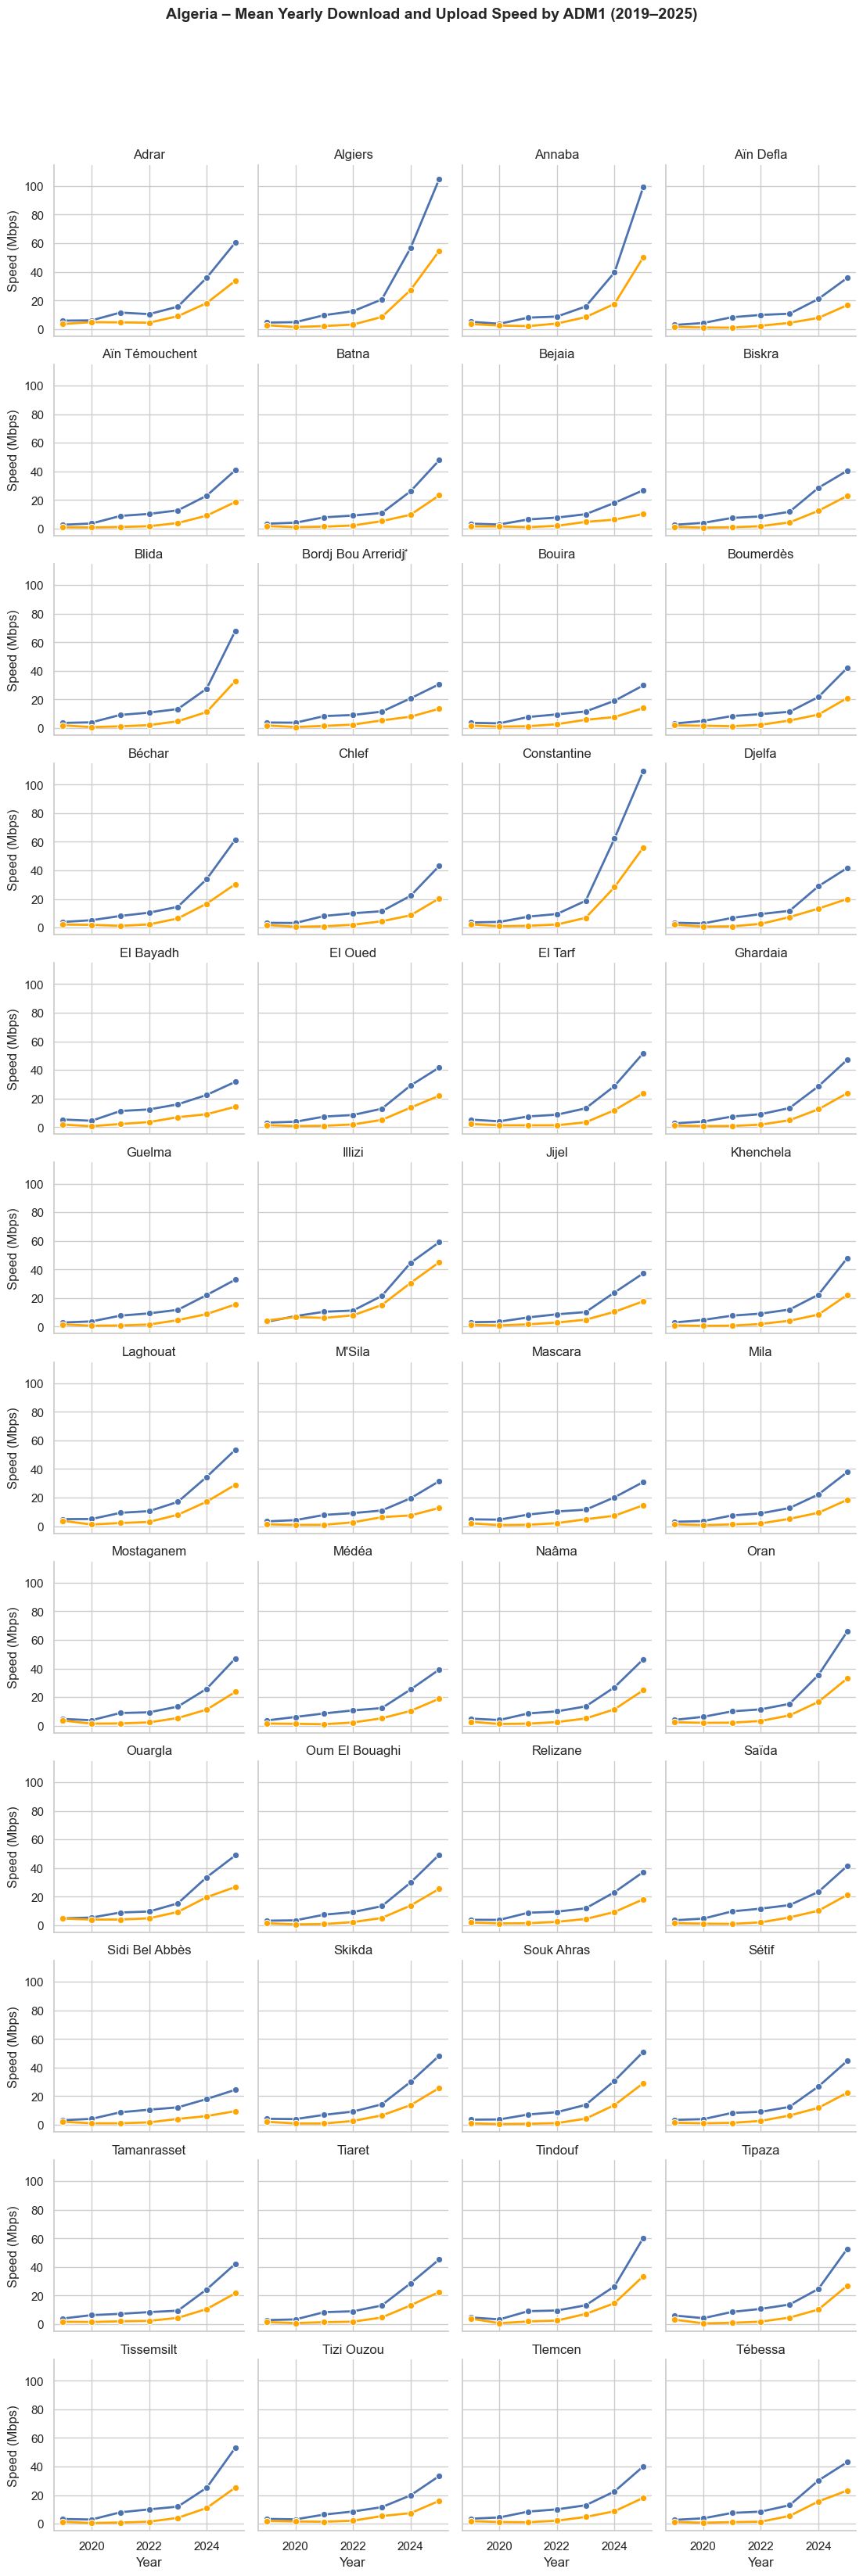

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv(str(DATA_DIR) + "algeria_subnational_trends_fixed.csv")

adm1 = df[df["admin_level"] == "ADM1"].copy()
adm1["year"] = adm1["date"].str.slice(0, 4).astype(int)
yearly = (adm1.groupby(["admin_name", "year"], as_index=False)[["avg_download_mbps", "avg_upload_mbps"]]
               .mean()
               .rename(columns={"avg_download_mbps": "download_mbps", "avg_upload_mbps": "upload_mbps"}))

sns.set_theme(style="whitegrid")
g = sns.FacetGrid(yearly.sort_values("admin_name"),
                  col="admin_name", col_wrap=4, height=2.8, sharey=True)
g.map_dataframe(sns.lineplot, x="year", y="download_mbps", marker="o", linewidth=2)
g.map_dataframe(sns.lineplot, x="year", y="upload_mbps", marker="o", linewidth=2, color='orange', legend=True)
g.set_axis_labels("Year", "Speed (Mbps)")
g.set_titles("{col_name}")
plt.subplots_adjust(top=0.92)
g.fig.suptitle("Algeria – Mean Yearly Download and Upload Speed by ADM1 (2019–2025)", fontsize=14, weight="bold")
plt.show()


# Trends -  ADMN3

The figures below show maps at admin level 3 between 2019 and 2025. You can filter to view trends in download, upload and latency.

In [5]:
import pandas as pd

from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource, HoverTool, Select, CustomJS
from bokeh.plotting import figure
from bokeh.layouts import column

output_notebook(hide_banner=True)

df = pd.read_csv("processed_data/algeria_subnational_trends_fixed.csv", encoding="utf-8-sig")

adm3 = df[df["admin_level"] == "ADM3"].copy()
adm3["year"] = adm3["date"].astype(str).str.slice(0, 4).astype(int)

adm3["admin_name"] = adm3["admin_name"].astype(str).str.strip()
valid_names = (
    adm3["admin_name"].notna()
    & (adm3["admin_name"] != "")
    & ~adm3["admin_name"].str.contains(r"\?")
    & adm3["admin_name"].str.match(r"^[A-Za-zÀ-ÿ'\-\s]+$")
)
adm3 = adm3[valid_names]

yearly = (
    adm3.groupby(["admin_name", "year"], as_index=False)
        .agg(
            download=("avg_download_mbps", "mean"),
            upload=("avg_upload_mbps", "mean")
        )
)

wilayas = sorted(yearly["admin_name"].unique().tolist())
default_w = wilayas[0]

data_map = {
    w: {
        "year": yearly.loc[yearly.admin_name.eq(w), "year"].tolist(),
        "download": yearly.loc[yearly.admin_name.eq(w), "download"].tolist(),
        "upload": yearly.loc[yearly.admin_name.eq(w), "upload"].tolist(),
    }
    for w in wilayas
}

src = ColumnDataSource(data=data_map[default_w])

p = figure(
    height=420,
    width=820,
    title=f"Yearly Speed – {default_w}",
    x_axis_label="Year",
    y_axis_label="Mbps",
    tools="pan,wheel_zoom,box_zoom,reset,save,hover",
    toolbar_location="right"
)

p.line("year", "download", source=src, line_width=3, legend_label="Download", line_color="steelblue")
p.scatter("year", "download", source=src, size=7, color="steelblue")
p.line("year", "upload",   source=src, line_width=3, legend_label="Upload",   line_color="orange")
p.scatter("year", "upload", source=src, size=7, color="orange")

p.legend.click_policy = "hide"
p.select_one(HoverTool).tooltips = [
    ("Year", "@year"),
    ("Download", "@download{0.00}"),
    ("Upload", "@upload{0.00}")
]

selector = Select(title="Commune (ADM3):", value=default_w, options=wilayas)

selector.js_on_change(
    "value",
    CustomJS(args=dict(src=src, dataMap=data_map, fig=p), code="""
        const w = cb_obj.value;
        const d = dataMap[w];
        src.data = {year: d.year, download: d.download, upload: d.upload};
        src.change.emit();
        fig.title.text = `Yearly Speed – ${w}`;
    """)
)

show(column(selector, p))


In [12]:
import json
import numpy as np
import pandas as pd
import geopandas as gpd

from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.layouts import gridplot
from bokeh.models import (
    GeoJSONDataSource, LinearColorMapper, ColorBar, FixedTicker, HoverTool, Div
)
from bokeh.palettes import brewer

output_notebook(hide_banner=True)

# CONFIG

ADM3_GEO = "./geoBoundaries-DZA-ADM3.geojson"
SUBNAT_CSV = "./processed_data/algeria_subnational_trends_fixed.csv"
YEARS = list(range(2019, 2025 + 1))

METRIC_COLUMNS = {
    "Download (Mbps)": "avg_download_mbps",
    "Upload (Mbps)":   "avg_upload_mbps",
    "Latency (ms)":    "avg_latency_ms",
}



g_adm3 = gpd.read_file(ADM3_GEO)[["shapeName", "geometry"]].rename(
    columns={"shapeName": "admin_name"}
).to_crs(4326)

g_adm3["geometry"] = g_adm3.geometry.simplify(tolerance=0.01, preserve_topology=True)


df = pd.read_csv(SUBNAT_CSV, encoding="utf-8")
df = df[df["admin_level"] == "ADM3"].copy()

if "year" not in df.columns and "date" in df.columns:
    df["year"] = df["date"].astype(str).str[:4].astype(int)

df = df[df["year"].between(min(YEARS), max(YEARS))]

yearly_data = df.groupby(["admin_name", "year"], as_index=False).agg({
    col: "median" for col in METRIC_COLUMNS.values() if col in df.columns
})
data_wide = yearly_data.pivot(index="admin_name", columns="year")

gdf_full = g_adm3.copy()
for metric_label, metric_col in METRIC_COLUMNS.items():
    if metric_col in df.columns:
        for y in YEARS:
            col_name = f"{metric_col}_{y}"
            if (metric_col, y) in data_wide.columns:
                year_data = data_wide[(metric_col, y)].reset_index()
                year_data.columns = ["admin_name", col_name]
                gdf_full = gdf_full.merge(year_data, on="admin_name", how="left")

source = GeoJSONDataSource(geojson=gdf_full.to_json())



def _bivariate_palette():
    # 3x3 palette: rows = upload (low→high), cols = download (low→high)
    return [
        ["#e8e8e8", "#ace4e4", "#5ac8c8"],  # upload low
        ["#dfb0d6", "#a5add3", "#5698b9"],  # upload mid
        ["#be64ac", "#8c62aa", "#3b4994"],  # upload high
    ]

def _bin_series_to_tertiles_values(values):
    values = np.asarray(values, dtype=float)
    finite = values[np.isfinite(values)]
    if finite.size == 0:
        return [0.0, 1.0]
    return list(np.percentile(finite, [33.3333, 66.6667]))

def _bin_with_thresholds(series, q):
    def _b(v):
        if not np.isfinite(v): return np.nan
        return 0 if v <= q[0] else (1 if v <= q[1] else 2)
    return series.apply(_b).astype("Float64")

def _ensure_bivariate_columns(gdf, years, dl_col, ul_col):
    missing_any = any(f"{dl_col}_{y}" not in gdf.columns or f"{ul_col}_{y}" not in gdf.columns for y in years)
    if missing_any:
        raise ValueError("Download/Upload columns per year are missing.")

    dl_all, ul_all = [], []
    for y in years:
        if f"{dl_col}_{y}" in gdf.columns:
            dl_all.extend(gdf[f"{dl_col}_{y}"].values)
        if f"{ul_col}_{y}" in gdf.columns:
            ul_all.extend(gdf[f"{ul_col}_{y}"].values)

    dl_q = _bin_series_to_tertiles_values(dl_all)
    ul_q = _bin_series_to_tertiles_values(ul_all)
    palette = _bivariate_palette()

    for y in years:
        dcol = f"{dl_col}_{y}"
        ucol = f"{ul_col}_{y}"
        ccol = f"dl_ul_col_{y}"

        if dcol in gdf.columns and ucol in gdf.columns:
            d_bin = _bin_with_thresholds(gdf[dcol], dl_q)
            u_bin = _bin_with_thresholds(gdf[ucol], ul_q)

            colours = []
            for ub, db in zip(u_bin, d_bin):
                if pd.isna(ub) or pd.isna(db):
                    colours.append("#f0f0f0")
                else:
                    colours.append(palette[int(ub)][int(db)])
            gdf[ccol] = colours
        else:
            gdf[ccol] = "#f0f0f0"

    gdf["dl_q33"], gdf["dl_q66"] = dl_q[0], dl_q[1]
    gdf["ul_q33"], gdf["ul_q66"] = ul_q[0], ul_q[1]

# RENDER: Single combined view (Download + Upload) as bivariate + Latency

def render_bivariate_download_upload(years=YEARS):
    dl_label = "Download (Mbps)"
    ul_label = "Upload (Mbps)"
    dl_col = METRIC_COLUMNS[dl_label]
    ul_col = METRIC_COLUMNS[ul_label]

    if dl_col not in df.columns or ul_col not in df.columns:
        raise ValueError("Required columns for download/upload not found.")

    # Build bivariate colour columns and refresh source
    _ensure_bivariate_columns(gdf_full, years, dl_col, ul_col)
    source.geojson = gdf_full.to_json()

    show(Div(text=f"<h2 style='margin-bottom: 10px;'>Download vs Upload Speeds (2019-2025)</h2>"))

    figs = []
    for y in years:
        ccol = f"dl_ul_col_{y}"
        p = figure(
            title=str(y),
            width=300, height=300,
            tools="", toolbar_location=None
        )
        p.add_tools(HoverTool(tooltips=[
            ("Commune", "@admin_name"),
            (dl_label, f"@{dl_col}_{y}{{0.2f}}"),
            (ul_label, f"@{ul_col}_{y}{{0.2f}}"),
        ]))
        p.grid.visible = False
        p.axis.visible = False

        p.patches(
            xs="xs", ys="ys",
            source=source,
            fill_color=ccol,
            line_color="white",
            line_width=0.3,
            line_alpha=0.5
        )
        figs.append(p)

    legend = figure(width=300, height=300, toolbar_location=None,
                    title=f"{ul_label} ↑\n\n{dl_label} →")
    legend.grid.visible = False
    legend.axis.visible = False
    pal = _bivariate_palette()
    size = 1
    for i in range(3):          # upload bin
        for j in range(3):      # download bin
            legend.quad(left=j*size, right=(j+1)*size,
                        bottom=i*size, top=(i+1)*size,
                        fill_color=pal[i][j], line_color=None)
    figs.append(legend)

    grid = gridplot(figs, ncols=4, merge_tools=False, sizing_mode="scale_width")
    show(grid)

def render_latency(years=YEARS):
    metric_label = "Latency (ms)"
    metric_col = METRIC_COLUMNS[metric_label]
    if metric_col not in df.columns:
        raise ValueError(f"Column '{metric_col}' not found in data.")

    show(Div(text=f"<h2 style='margin-bottom: 10px;'>Latency (ms) 2019-2025</h2>"))

    vals_all = []
    for y in years:
        col_name = f"{metric_col}_{y}"
        if col_name in gdf_full.columns:
            vals_all.extend(gdf_full[col_name].dropna().values)

    if len(vals_all) == 0:
        vmin, vmax = 0.0, 1.0
    else:
        vmin = float(np.percentile(vals_all, 5))
        vmax = float(np.percentile(vals_all, 95))
        if vmin == vmax:
            vmax = vmin + 1.0

    palette = brewer["YlGnBu"][8][::-1]
    mapper = LinearColorMapper(palette=palette, low=vmin, high=vmax, nan_color="#f0f0f0")

    figs = []
    for y in years:
        col_name = f"{metric_col}_{y}"
        p = figure(
            title=str(y),
            width=300, height=300,
            tools="hover",
            toolbar_location=None
        )
        p.grid.visible = False
        p.axis.visible = False

        p.patches(
            xs="xs", ys="ys",
            source=source,
            fill_color={"field": col_name, "transform": mapper},
            line_color="white",
            line_width=0.3,
            line_alpha=0.5
        )

        hov = p.select_one(HoverTool)
        hov.tooltips = [
            ("Commune", "@admin_name"),
            (metric_label, f"@{col_name}{{0.2f}}")
        ]

        figs.append(p)

    color_bar_fig = figure(
        width=300, height=300,
        toolbar_location=None,
        outline_line_color=None
    )
    color_bar_fig.grid.visible = False
    color_bar_fig.axis.visible = False

    ticks = np.linspace(vmin, vmax, 6)
    color_bar = ColorBar(
        color_mapper=mapper,
        ticker=FixedTicker(ticks=list(ticks)),
        label_standoff=8,
        location=(0, 0),
        title=metric_label,
        title_text_font_size="10pt",
        major_label_text_font_size="9pt",
        width=20
    )
    color_bar_fig.add_layout(color_bar, "center")
    figs.append(color_bar_fig)

    grid = gridplot(figs, ncols=4, merge_tools=False, sizing_mode="scale_width")
    show(grid)


render_bivariate_download_upload()  
render_latency()                    


/Users/toweramoyo/anaconda3/envs/algeria_economic_monitoring/lib/python3.11/site-packages/shapely/constructive.py:1177: RuntimeWarning: invalid value encountered in simplify_preserve_topology
  return lib.simplify_preserve_topology(geometry, tolerance, **kwargs)


# Population-Weighted Internet Speed Trends


### Comparison - Download Data

In [6]:
import pandas as pd
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool, Legend

output_notebook(hide_banner=True)

df1 = pd.read_csv("./processed_data/algeria_national_trends_fixed.csv").copy()

df1['year'] = df1['date'].str.slice(0, 4).astype(int)
yearly = (df1.groupby('year', as_index=False)['avg_download_mbps']
          .mean().rename(columns={'avg_download_mbps': 'download_mbps'}))
yearly = yearly.sort_values('year')
src1 = ColumnDataSource(yearly)

df2 = pd.read_csv("processed_data/algeria_pop_weighted_trends_2019_2025_fixed.csv").copy()
df2 = df2.sort_values("year")
src2 = ColumnDataSource(df2)

p = figure(title="Algeria – Download Speed Trends (Mbps)",
           x_axis_type="linear", height=400, width=800,
           tools="pan,wheel_zoom,box_zoom,reset,save")

line1 = p.line('year', 'download_mbps', source=src1, line_width=3, legend_label="National Avg")
p.scatter('year', 'download_mbps', source=src1, size=8)

line2 = p.line('year', 'pw_download_mbps', source=src2, line_width=3, color='orange', legend_label="Population-weighted Avg")
p.scatter('year', 'pw_download_mbps', source=src2, size=8, color='orange')

p.add_tools(HoverTool(tooltips=[
    ("Year", "@year"),
    ("Download (Mbps)", "$y{0.00}")
], mode='vline'))

p.xaxis.axis_label = "Year"
p.yaxis.axis_label = "Download (Mbps)"
p.legend.location = "top_left"
p.legend.click_policy = "hide"

show(p)


In [7]:
import pandas as pd
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool, Legend

output_notebook(hide_banner=True)

df1 = pd.read_csv("./processed_data/algeria_national_trends_fixed.csv").copy()
df1['year'] = df1['date'].str.slice(0, 4).astype(int)
yearly = (df1.groupby('year', as_index=False)['avg_upload_mbps']
          .mean().rename(columns={'avg_upload_mbps': 'upload_mbps'}))
yearly = yearly.sort_values('year')
src1 = ColumnDataSource(yearly)

df2 = pd.read_csv("processed_data/algeria_pop_weighted_trends_2019_2025_fixed.csv").copy()
df2 = df2.sort_values("year")
src2 = ColumnDataSource(df2)

p = figure(title="Algeria – Upload Speed Trends (Mbps)",
           x_axis_type="linear", height=400, width=800,
           tools="pan,wheel_zoom,box_zoom,reset,save")

line1 = p.line('year', 'upload_mbps', source=src1, line_width=3, legend_label="National Avg")
p.scatter('year', 'upload_mbps', source=src1, size=8)

line2 = p.line('year', 'pw_upload_mbps', source=src2, line_width=3, color='orange', legend_label="Population-weighted Avg")
p.scatter('year', 'pw_upload_mbps', source=src2, size=8, color='orange')

p.add_tools(HoverTool(tooltips=[
    ("Year", "@year"),
    ("Download (Mbps)", "$y{0.00}")
], mode='vline'))

p.xaxis.axis_label = "Year"
p.yaxis.axis_label = "Upload (Mbps)"
p.legend.location = "top_left"
p.legend.click_policy = "hide"

show(p)


## Population-Weighted Average Download Analysis (ADMN 1)

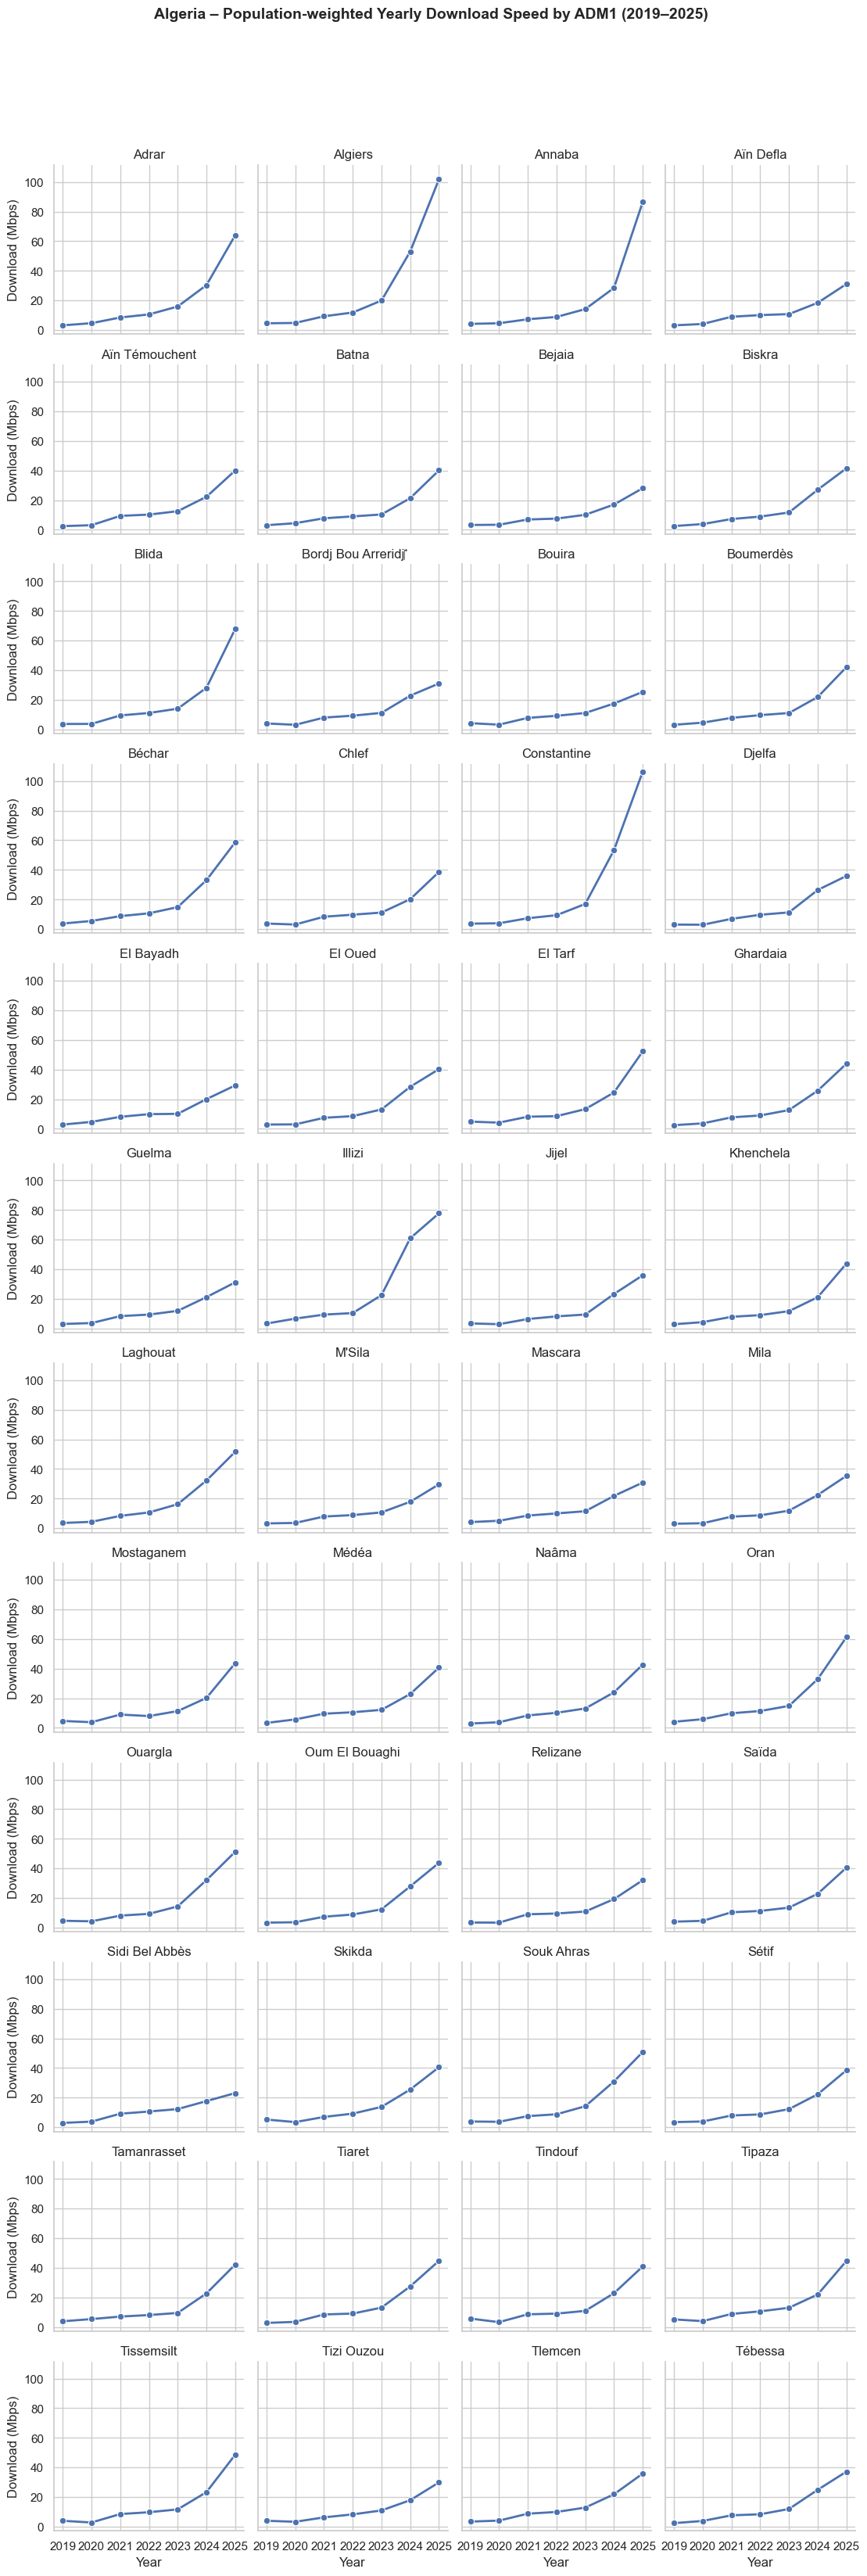

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("processed_data/algeria_pop_weighted_adm1_2019_2025_fixed.csv")

df["year"] = df["year"].astype(int)
yearly = (df[["adm1_name", "year", "pw_download_mbps"]]
            .rename(columns={"pw_download_mbps": "download_mbps"})
            .sort_values(["adm1_name", "year"]))

sns.set_theme(style="whitegrid")
g = sns.FacetGrid(yearly, col="adm1_name", col_wrap=4, height=2.8, sharey=True)
g.map_dataframe(sns.lineplot, x="year", y="download_mbps", marker="o", linewidth=2)
g.set_axis_labels("Year", "Download (Mbps)")
g.set_titles("{col_name}")
plt.subplots_adjust(top=0.92)
g.fig.suptitle("Algeria – Population-weighted Yearly Download Speed by ADM1 (2019–2025)", fontsize=14, weight="bold")

for ax in g.axes.flatten():
    ax.set_xticks(sorted(yearly["year"].unique()))

plt.show()


## Population-Weighted Average Upload Analysis (ADMN 1)

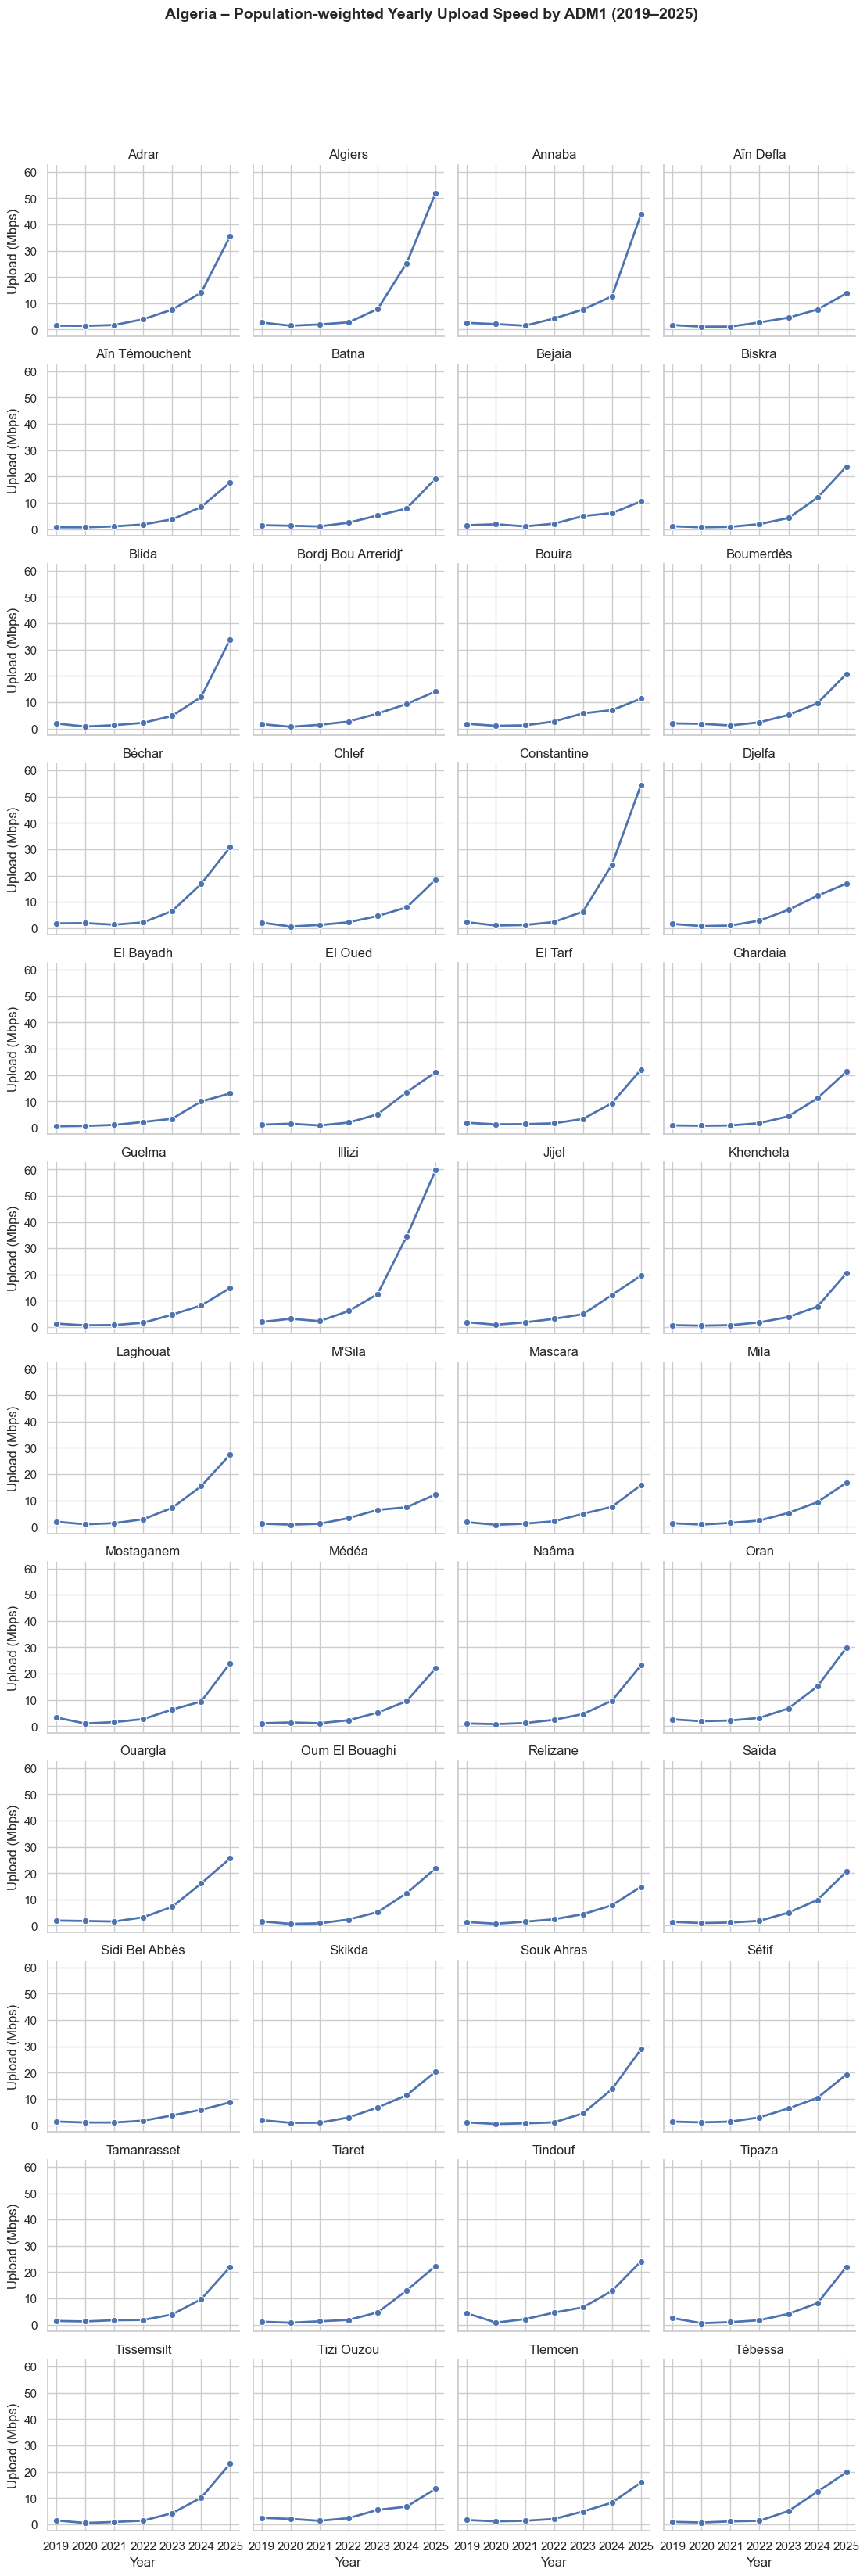

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("processed_data/algeria_pop_weighted_adm1_2019_2025_fixed.csv")

df["year"] = df["year"].astype(int)
yearly = (df[["adm1_name", "year", "pw_upload_mbps"]]
            .rename(columns={"pw_upload_mbps": "upload_mbps"})
            .sort_values(["adm1_name", "year"]))

sns.set_theme(style="whitegrid")
g = sns.FacetGrid(yearly, col="adm1_name", col_wrap=4, height=2.8, sharey=True)
g.map_dataframe(sns.lineplot, x="year", y="upload_mbps", marker="o", linewidth=2)
g.set_axis_labels("Year", "Upload (Mbps)")
g.set_titles("{col_name}")
plt.subplots_adjust(top=0.92)
g.fig.suptitle("Algeria – Population-weighted Yearly Upload Speed by ADM1 (2019–2025)", fontsize=14, weight="bold")

for ax in g.axes.flatten():
    ax.set_xticks(sorted(yearly["year"].unique()))

plt.show()
